In [1]:
import sys
sys.path.append('..')

from utils.misc import *
from utils.classifier import *
from utils.visualiser import *

## Loading data

In [2]:
df_train_b1_se_f2 = pd.read_csv("../data/b1/df_train_b1_se_f2.csv", index_col=0)

In [3]:
df = df_train_b1_se_f2.copy()
df_wap = df_train_b1_se_f2.loc[:, :'WAP503']

## Room classification

In [ ]:
kwargs = {
    'target'    : 'room',
    'classifier': 'svm',
}

best_estimator, cvs = tune_parameter(data=df, wap=df_wap, **kwargs)
print("Average balanced accuracy: %.2f%% ± %.2f%%" % (mean_ci(cvs)[0]* 100, mean_ci(cvs)[1] * 100))

In [6]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
cvs = cross_val_score(clf, df_wap.astype(bool), df['LOC'], scoring=make_scorer(balanced_accuracy_score), cv=10)
print("Average balanced accuracy: %.2f%% ± %.2f%%" % (mean_ci(cvs)[0]* 100, mean_ci(cvs)[1] * 100))

Average balanced accuracy: 90.60% ± 7.22%


## Further data exploration

In [7]:
wap_in_use = [i for i in df_wap if df_wap[i].nunique() != 1]
print("There are %d WAPs used." % len(wap_in_use))

df_wap = df_wap[wap_in_use]

There are 90 WAPs used.


In [8]:
# number of samples in each room
df.groupby(['LOC', 'LATITUDE', 'LONGITUDE']).size()

LOC  LATITUDE      LONGITUDE   
196  4.864815e+06  -7469.889200    20
199  4.864834e+06  -7469.328742    20
200  4.864820e+06  -7466.963700    24
204  4.864852e+06  -7461.524049     7
205  4.864810e+06  -7460.767900    20
207  4.864815e+06  -7457.755500    20
209  4.864831e+06  -7457.927200    20
210  4.864852e+06  -7458.264200    29
212  4.864854e+06  -7457.242100    38
214  4.864829e+06  -7453.059500    20
dtype: int64

In [9]:
# number of unique visitors in each room
unique_users = pd.DataFrame(df.groupby(['LOC', 'LATITUDE', 'LONGITUDE', 'USERID']).size()).reset_index()

"""
unique_users['GPS'] = '(' + round(unique_users['LATITUDE'], 6).astype(str) + ', ' \
                       + round(unique_users['LONGITUDE'], 6).astype(str) + ')'
"""
# unique_users.to_csv("unique_users.csv")

"\nunique_users['GPS'] = '(' + round(unique_users['LATITUDE'], 6).astype(str) + ', '                        + round(unique_users['LONGITUDE'], 6).astype(str) + ')'\n"

In [10]:
from collections import defaultdict

common_waps = defaultdict(dict)
wap_names = defaultdict(dict)
sample_counts = dict(df.groupby(['LOC']).size())
print("For users who have been to floor 2")
for loc in np.unique(df['LOC']):
    n_samples = sample_counts[loc]
    data = df_wap.loc[df[df['LOC'] == loc].index]
    cols = np.where(data.astype(bool).astype(int).sum(axis=0) == n_samples)[0]
    wap_names[loc] = np.asarray(data.columns[cols])
    common_waps[loc] = [n_samples, data.columns[cols]]
    print("Location [%s] has [%2d] repeated WAPs in all [%2d] samples" 
          % (loc, len(cols), n_samples))

For users who have been to floor 2
Location [196] has [20] repeated WAPs in all [20] samples
Location [199] has [12] repeated WAPs in all [20] samples
Location [200] has [14] repeated WAPs in all [24] samples
Location [204] has [16] repeated WAPs in all [ 7] samples
Location [205] has [12] repeated WAPs in all [20] samples
Location [207] has [13] repeated WAPs in all [20] samples
Location [209] has [11] repeated WAPs in all [20] samples
Location [210] has [ 1] repeated WAPs in all [29] samples
Location [212] has [ 6] repeated WAPs in all [38] samples
Location [214] has [12] repeated WAPs in all [20] samples


In [11]:
wap_usage = set([wap for ls in wap_names.values() for wap in ls])
print("There are %d repeated WAPs." % len(wap_usage))

wap_usage = pd.DataFrame(0, index=wap_usage, columns=wap_names.keys())

for loc, wap in wap_names.items():
    wap_usage.loc[wap, loc] = 1

wap_usage.sort_index(inplace=True)
# wap_usage.to_csv("../data/b1/wap_usage_b1_se.csv")

There are 34 repeated WAPs.


In [12]:
def highlight_cell(val):
    color = 'yellow' if val == 1 else ''
    return 'background-color: %s' % color

wap_usage.style.applymap(highlight_cell)

,196,199,200,204,205,207,209,210,212,214
WAP015,1,0,0,1,0,0,0,0,0,0
WAP016,1,0,1,1,0,0,0,0,0,0
WAP082,1,0,0,0,0,0,0,0,0,0
WAP083,1,0,1,0,0,1,0,0,0,0
WAP085,0,0,0,0,0,1,0,0,0,0
WAP109,1,1,1,0,1,0,1,0,0,1
WAP110,1,1,1,0,1,1,1,0,0,1
WAP111,1,0,1,0,1,1,0,0,0,1
WAP112,1,0,1,0,1,1,1,0,0,0
WAP115,0,0,0,1,0,0,0,0,1,0


Use repeated WAPs to predict room locations

In [20]:
kwargs = {
    'target'    : 'room',
    'classifier': 'svm',
}

best_estimator, cvs = tune_parameter(data=df, wap=df_wap[wap_usage.index], **kwargs)
print("Average balanced accuracy: %.2f%% ± %.2f%%" % (mean_ci(cvs)[0]* 100, mean_ci(cvs)[1] * 100))

BEST PARAMS: {'C': 0.005}
Average balanced accuracy: 95.89% ± 3.24%


In [13]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
cvs = cross_val_score(clf, df_wap[wap_usage.index].astype(bool), df['LOC'], scoring=make_scorer(balanced_accuracy_score), cv=10)
print("Average balanced accuracy: %.2f%% ± %.2f%%" % (mean_ci(cvs)[0]* 100, mean_ci(cvs)[1] * 100))

Average balanced accuracy: 77.59% ± 5.11%


In [22]:
df_train_b1_se_f2.loc[:, :'WAP503']

,WAP006,WAP015,WAP016,WAP059,WAP077,WAP078,WAP082,WAP083,WAP084,WAP085,...,WAP375,WAP386,WAP390,WAP394,WAP396,WAP398,WAP400,WAP405,WAP478,WAP503
41,0,0,0,0,0,0,0,0,0,0,...,0,11,22,0,0,0,20,0,0,0
45,0,15,14,0,0,0,0,0,0,0,...,0,10,0,0,0,0,16,21,0,0
48,0,13,14,0,0,0,0,0,0,0,...,0,0,19,0,11,0,23,0,0,0
157,0,12,14,0,0,0,0,0,0,0,...,0,11,19,0,0,0,26,24,0,0
158,11,0,0,0,0,0,0,0,0,0,...,0,9,0,0,21,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046,0,0,13,0,0,0,20,19,17,13,...,0,0,0,0,0,0,0,0,0,0
7048,0,0,15,0,0,0,19,22,19,20,...,0,15,0,0,0,0,0,0,0,0
7049,0,17,15,0,0,0,0,0,0,0,...,13,0,19,0,0,0,15,0,0,0
7050,0,0,0,0,0,0,0,0,0,0,...,0,17,0,0,0,0,0,0,0,0


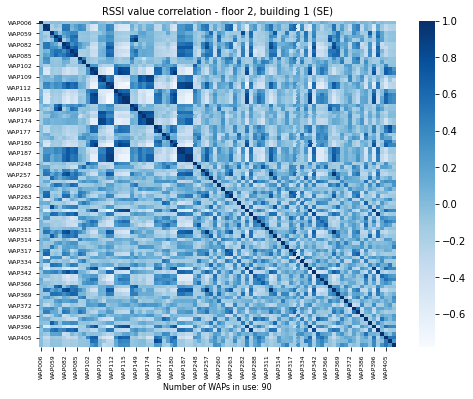

In [15]:
wap_heatmap(df_wap, 'floor 2, building 1 (SE)', save=True)

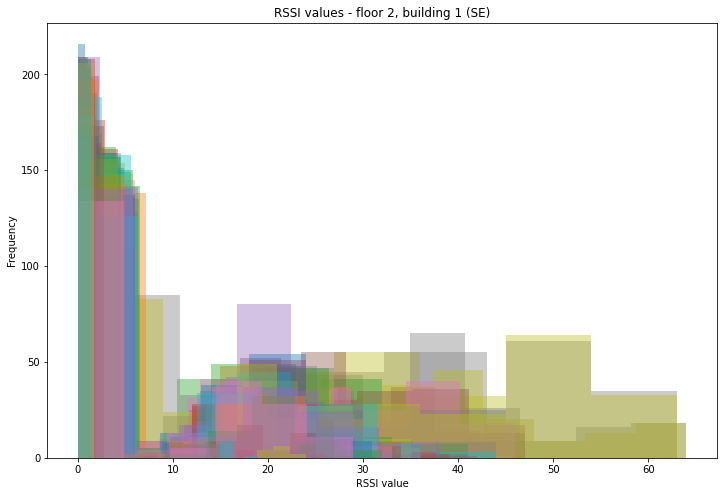

In [16]:
plt.figure(figsize=(12, 8))
for col in df_wap.columns:
    sns.distplot(df_wap[col], kde=False)
plt.xlabel("RSSI value")
plt.ylabel("Frequency")
plt.title("RSSI values - floor 2, building 1 (SE)")
plt.savefig("../visualisation/rss_b1_f2_se.png", dpi=300, transparent=True)
plt.show()